# 分位点回帰＋スプライン

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

import japanize_matplotlib

# 色テーマ指定
plt.style.use("ggplot")

元データ：改訂版 日本統計学会公式認定　統計検定2級対応　統計学基礎 配布データ http://tokyo-tosho.co.jp/download/


In [2]:
df = pd.read_csv("../data/room.csv", encoding="cp932")
df.head()

,近さ,家賃,間取り,大きさ,方角,築年数
0,B,68000,1K,19,西,12
1,B,68000,1K,19,南,12
2,B,69000,1K,19,北西,14
3,B,70000,1K,19,南,14
4,B,72000,1K,15,南,9


(0.0, 154100.0)

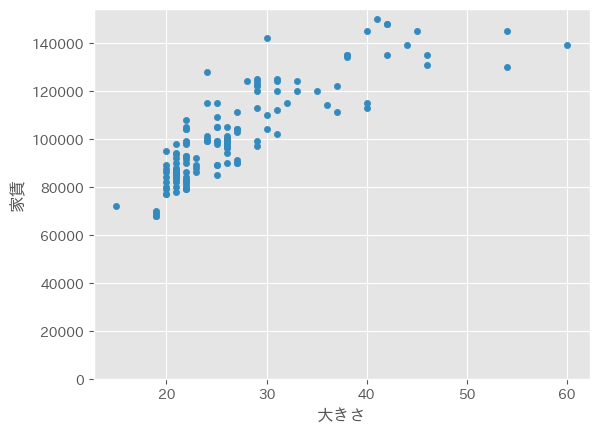

In [3]:
df.plot.scatter(x="大きさ", y="家賃")
plt.ylim(0, None)

In [4]:
# ３次スプライン
xmin, xmax = 15, 60
x_lin = np.arange(xmin, xmax)

def PolyBasis(x, p=5):
    pwr = np.arange(p + 1)
    return x[:, None] ** pwr[None]

def CubicSplineBasis(x, n=3, xmin=xmin, xmax=xmax):
    knots = np.linspace(xmin, xmax, num=n - 1, endpoint=False)
    phi = PolyBasis(x, p=3)

    tps3 = x[:, None] - knots[None]
    tps3 = np.where(tps3 > 0, tps3, 0) ** 3

    phi = np.concatenate([phi, tps3], axis=1)
    return phi

# 線形・非線形回帰

(0.0, 173440.18041243416)

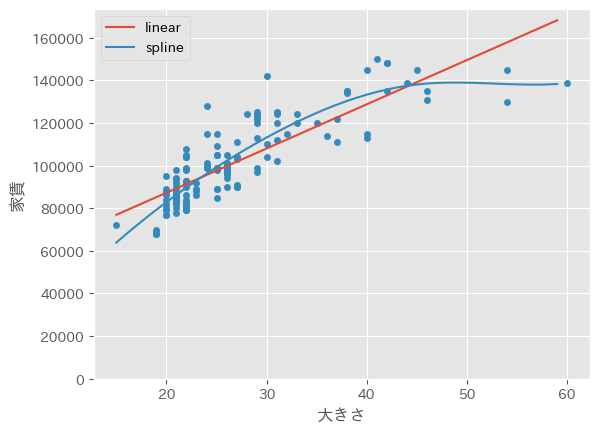

In [5]:
n_seg = 4 # 区分数

ols_lr = sm.OLS(endog=df["家賃"], exog=sm.add_constant(df["大きさ"])).fit()
ols_spline = sm.OLS(endog=df["家賃"], exog=CubicSplineBasis(df["大きさ"].values, n=n_seg)).fit()

df.plot.scatter(x="大きさ", y="家賃")
plt.plot(x_lin, ols_lr.predict(sm.add_constant(x_lin)), label="linear")
plt.plot(x_lin, ols_spline.predict(CubicSplineBasis(x_lin, n=n_seg)), label="spline")

plt.legend()
plt.ylim(0, None)

n_seg=2: AIC=2956.7549994629567
n_seg=3: AIC=2958.7415114824335
n_seg=4: AIC=2960.516832513759
n_seg=5: AIC=2961.930806601096


Text(0.5, 1.0, 'AIC最小区分数=2')

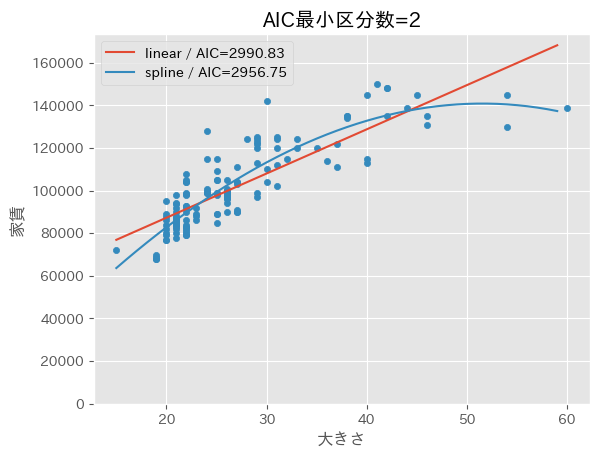

In [11]:
# 区分数の選択
aic_min = np.inf
n_seg_best = None
for n_seg in range(2,6):
    ols_spline = sm.OLS(endog=df["家賃"], exog=CubicSplineBasis(df["大きさ"].values, n=n_seg)).fit()
    print(f"{n_seg=}: AIC={ols_spline.aic}")
    if ols_spline.aic < aic_min:
        aic_min = ols_spline.aic
        n_seg_best = n_seg

ols_spline = sm.OLS(endog=df["家賃"], exog=CubicSplineBasis(df["大きさ"].values, n=n_seg_best)).fit()

df.plot.scatter(x="大きさ", y="家賃")
plt.plot(x_lin, ols_lr.predict(sm.add_constant(x_lin)), label="linear / AIC={:.2f}".format(ols_lr.aic))
plt.plot(x_lin, ols_spline.predict(CubicSplineBasis(x_lin, n=n_seg_best)), label="spline / AIC={:.2f}".format(ols_spline.aic))

plt.legend()
plt.ylim(0, None)
plt.title("AIC最小区分数={}".format(n_seg_best))

# 分位点回帰

/home/hayato/.pyenv/versions/miniconda3-latest/envs/main/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


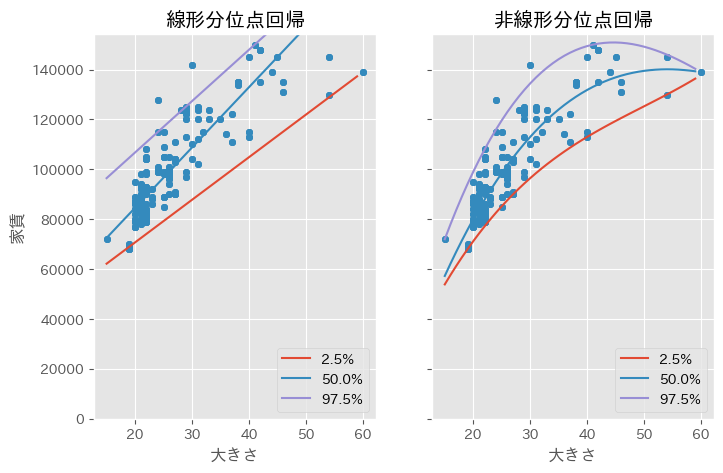

In [15]:
n_seg = 2 # 区分数
qs = [0.025, 0.50, 0.975]
qrs_lr = dict()
qrs_spline = dict()

for q in qs:
    qrs_lr[q] = sm.QuantReg(endog=df["家賃"], exog=sm.add_constant(df["大きさ"])).fit(q=q)
    qrs_spline[q] = sm.QuantReg(endog=df["家賃"], exog=CubicSplineBasis(df["大きさ"].values, n=n_seg)).fit(q=q)



fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
for q in qs:
    df.plot.scatter(x="大きさ", y="家賃", ax=axes[0])
    axes[0].plot(x_lin, qrs_lr[q].predict(sm.add_constant(x_lin)), label="{:.1f}%".format(100*q))
    axes[0].legend(loc="lower right")
    axes[0].set_ylim(0, None)
    axes[0].set_title("線形分位点回帰")

    df.plot.scatter(x="大きさ", y="家賃", ax=axes[1])
    axes[1].plot(x_lin, qrs_spline[q].predict(CubicSplineBasis(x_lin, n=n_seg)), label="{:.1f}%".format(100*q))
    axes[1].legend(loc="lower right")
    axes[1].set_ylim(0, None)
    axes[1].set_title("非線形分位点回帰")


